<a href="https://colab.research.google.com/github/bmoretz/MSDS-MachineLearning/blob/master/Assignment_08/Assignment_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workspace Initialization

## Libraries & Standard Setup

In [0]:
!pip install -U -q PyDrive

In [0]:
%matplotlib inline

import os
import io

# Core
import pandas as pd
import numpy as np

# Data
import json
from collections import defaultdict

# Visuals
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Text
import re  # regular expressions

# Url
import urllib.parse

# Display Images
from PIL import Image, ImageFilter

# IPython display
from IPython.display import display

# Loading Zip Files
import zipfile

# Working with images
import cv2

# Progress Bar (for long processes)
from tqdm import tqdm

In [0]:
!pip install -U -q chakin

In [0]:
import tensorflow as tf
import time
import chakin

*lists available indices in English*

In [11]:
chakin.search(lang='English')

                   Name  Dimension                     Corpus VocabularySize  \
2          fastText(en)        300                  Wikipedia           2.5M   
11         GloVe.6B.50d         50  Wikipedia+Gigaword 5 (6B)           400K   
12        GloVe.6B.100d        100  Wikipedia+Gigaword 5 (6B)           400K   
13        GloVe.6B.200d        200  Wikipedia+Gigaword 5 (6B)           400K   
14        GloVe.6B.300d        300  Wikipedia+Gigaword 5 (6B)           400K   
15       GloVe.42B.300d        300          Common Crawl(42B)           1.9M   
16      GloVe.840B.300d        300         Common Crawl(840B)           2.2M   
17    GloVe.Twitter.25d         25               Twitter(27B)           1.2M   
18    GloVe.Twitter.50d         50               Twitter(27B)           1.2M   
19   GloVe.Twitter.100d        100               Twitter(27B)           1.2M   
20   GloVe.Twitter.200d        200               Twitter(27B)           1.2M   
21  word2vec.GoogleNews        300      

## Globals

- Specify English embeddings file to download and install by index number, number of dimensions, and subfoder name
- Note that GloVe 50-, 100-, 200-, and 300-dimensional folders are downloaded with a single zip download

In [0]:
RANDOM_SEED = 42

CHAKIN_INDEX = 11
NUMBER_OF_DIMENSIONS = 50
SUBFOLDER_NAME = "gloVe.6B"

EMBEDDINGS_FOLDER = "/content/drive/My Drive/datasets/movie_reviews/embeddings/gloVe.6B/"
EMBEDDINGS_FILE_50 = "glove.6B.50d.txt"
EMBEDDINGS_FILE_100 = "glove.6B.50d.txt"

MOVE_REVIEWS = "/content/drive/My Drive/datasets/movie_reviews/"
MOVE_REVIEWS_POS = "movie-reviews-positive"
MOVE_REVIEWS_NEG = "movie-reviews-negative"

- No stopword removal

In [0]:
REMOVE_STOPWORDS = False

- Specify desired size of pre-defined embedding vocabulary

In [0]:
EVOCABSIZE = 10000

Function to make output stable across runs.

In [0]:
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Project Dataset

## Embeddings Dataset

Load the "movie reviews" dataset from mounted drive.

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Utility function for loading embeddings.

- Creates the Python defaultdict dictionary **word_to_embedding_dict** for the requested pre-trained word embeddings

Note:

- The use of defaultdict data structure from the Python Standard Library collections_defaultdict.py lets the caller specify a default value up front 
- The default value will be retuned if the key is not a known dictionary key. That is, unknown words are represented by a vector of zeros.
- For word embeddings, this default value is a vector of zeros
- Documentation for the Python standard library:

In [0]:
def load_embedding_from_disks(embeddings_filename, with_indexes=True):
    """
    Read a embeddings txt file. If `with_indexes=True`, 
    we return a tuple of two dictionnaries
    `(word_to_index_dict, index_to_embedding_array)`, 
    otherwise we return only a direct 
    `word_to_embedding_dict` dictionnary mapping 
    from a string to a numpy array.
    """
    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []
  
    else:
        word_to_embedding_dict = dict()

    with open(embeddings_filename, 'r', encoding='utf-8') as embeddings_file:
        for (i, line) in enumerate(embeddings_file):

            split = line.split(' ')

            word = split[0]

            representation = split[1:]
            representation = np.array(
                [float(val) for val in representation]
            )

            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation

    # Empty representation for unknown words.
    _WORD_NOT_FOUND = [0.0] * len(representation)
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(
            lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(
            index_to_embedding_array + [_WORD_NOT_FOUND])
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict

In [0]:
embedding_file_50 = urllib.parse.urljoin(EMBEDDINGS_FOLDER, EMBEDDINGS_FILE_50)

In [19]:
display('Loading embeddings from: {}'.format(embedding_file_50))

'Loading embeddings from: /content/drive/My Drive/datasets/movie_reviews/embeddings/gloVe.6B/glove.6B.50d.txt'

In [0]:
word_to_index, index_to_embedding = \
    load_embedding_from_disks(embedding_file_50, with_indexes=True)

In [21]:
display('Loaded Word to Index: {}, Indexes: {}'.format(len(word_to_index), len(index_to_embedding)))

'Loaded Word to Index: 400000, Indexes: 400001'

## Data Set Exploration

In [0]:
vocab_size, embedding_dim = index_to_embedding.shape

In [23]:
display("Embedding is of shape: {}".format(index_to_embedding.shape))

'Embedding is of shape: (400001, 50)'

This means (number of words, number of dimensions per word)
The first words are words that tend occur more often.

Note: 
- for unknown words, the representation is an empty vector, and the index is the last one. The dictionnary has a limit:

In [24]:
display("    {} --> {} --> {}".format("A word", "Index in embedding", 
      "Representation"))

'    A word --> Index in embedding --> Representation'

### Sanity Checks of the Data

In [0]:
def get_word_index(word):
  idx = word_to_index[word]
  complete_vocabulary_size = idx
  embd = list(np.array(index_to_embedding[idx], dtype=int))
  return idx, embd

A word obviously not in the vocabulary:

In [35]:
word = "worsdfkljsdf"

idx, embd = get_word_index(word)
display("    {} --> {} --> {}".format(word, idx, embd))

'    worsdfkljsdf --> 400000 --> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'

Save the index as the word wasn't found, it denotes the full vocabulary size.

In [0]:
complete_vocabulary_size = idx

A word that should be in the vocabulary.

In [37]:
word = "the"

idx, embd = get_word_index(word)
display("    {} --> {} --> {}".format(word, idx, embd))

'    the --> 0 --> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'

### Sentence Testing

Let's test a simple sentence and <a href="https://en.wikipedia.org/wiki/The_quick_brown_fox_jumps_over_the_lazy_dog">famous phrase</a>.

In [38]:
a_typing_test_sentence = 'The quick brown fox jumps over the lazy dog'
display('Test sentence: {}'.format(a_typing_test_sentence))

'Test sentence: The quick brown fox jumps over the lazy dog'

In [39]:
words_in_test_sentence = a_typing_test_sentence.split()
display('{}'.format(words_in_test_sentence))

"['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']"

In [40]:
display('Test sentence embeddings from complete vocabulary of {} words.'.format(complete_vocabulary_size))

'Test sentence embeddings from complete vocabulary of 400000 words.'

In [41]:
for word in words_in_test_sentence:
    word_ = word.lower()
    embedding = index_to_embedding[word_to_index[word_]]
    print(word_ + ": ", embedding)

the:  [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]
quick:  [ 0.13967   -0.53798   -0.18047   -0.25142    0.16203   -0.13868
 -0.24637    0.75111    0.27264    0.61035   -0.82548    0.038647
 -0.32361    0.30373   -0.14598   -0.23551    0.39267   -1.1287
 -0.23636   -1.0629     0.046277   0.29143   -0.25819   -0.094902
  0.79478   -1.2095    -0.01039   -0.092086   0.84322   -0.11061
  3.0096     0.51652   -0.76986    0.51074    0.37

### Vocabulary

Define vocabulary size for the language model, to reduce the size of the vocabulary to the n most frequently used words

last/unknown-word row in limited_index_to_embedding

In [0]:
def default_factory():
    return EVOCABSIZE 

dictionary has the items() function, returns list of (key, value) tuples

In [0]:
limited_word_to_index = defaultdict(default_factory, \
    {k: v for k, v in word_to_index.items() if v < EVOCABSIZE})

Select the first EVOCABSIZE rows to the index_to_embedding.

In [0]:
limited_index_to_embedding = index_to_embedding[0:EVOCABSIZE,:]

Set the unknown-word row to be all zeros as previously.

In [0]:
limited_index_to_embedding = np.append(limited_index_to_embedding, 
    index_to_embedding[index_to_embedding.shape[0] - 1, :].\
        reshape(1,embedding_dim), 
    axis = 0)

Delete large numpy array to clear some CPU RAM.

In [0]:
del index_to_embedding

Verify the new vocabulary: should get same embeddings for test sentence

Note:
- that a small EVOCABSIZE may yield some zero vectors for embeddings

In [47]:
display('\nTest sentence embeddings from vocabulary of {} words.'.format(EVOCABSIZE))

for word in words_in_test_sentence:
    word_ = word.lower()
    embedding = limited_index_to_embedding[limited_word_to_index[word_]]
    display(' word: {} : embedding: {}'.format( word_, embedding))

'\nTest sentence embeddings from vocabulary of 10000 words.'

' word: the : embedding: [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02\n -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01\n -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01\n -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01\n -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01\n  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03\n  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01\n -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01\n -1.1514e-01 -7.8581e-01]'

' word: quick : embedding: [ 0.13967   -0.53798   -0.18047   -0.25142    0.16203   -0.13868\n -0.24637    0.75111    0.27264    0.61035   -0.82548    0.038647\n -0.32361    0.30373   -0.14598   -0.23551    0.39267   -1.1287\n -0.23636   -1.0629     0.046277   0.29143   -0.25819   -0.094902\n  0.79478   -1.2095    -0.01039   -0.092086   0.84322   -0.11061\n  3.0096     0.51652   -0.76986    0.51074    0.37508    0.12156\n  0.082794   0.43605   -0.1584    -0.61048    0.35006    0.52465\n -0.51747    0.0034705  0.73625    0.16252    0.85279    0.85268\n  0.57892    0.64483  ]'

' word: brown : embedding: [-0.88497   0.71685  -0.40379  -0.10698   0.81457   1.0258   -1.2698\n -0.49382  -0.27839  -0.92251  -0.49409   0.78942  -0.20066  -0.057371\n  0.060682  0.30746   0.13441  -0.49376  -0.54788  -0.81912  -0.45394\n  0.52098   1.0325   -0.8584   -0.65848  -1.2736    0.23616   1.0486\n  0.18442  -0.3901    2.1385   -0.45301  -0.16911  -0.46737   0.15938\n -0.095071 -0.26512  -0.056479  0.63849  -1.0494    0.037507  0.76434\n -0.6412   -0.59594   0.46589   0.31494  -0.34072  -0.59167  -0.31057\n  0.73274 ]'

' word: fox : embedding: [ 0.44206   0.059552  0.15861   0.92777   0.1876    0.24256  -1.593\n -0.79847  -0.34099  -0.24021  -0.32756   0.43639  -0.11057   0.50472\n  0.43853   0.19738  -0.1498   -0.046979 -0.83286   0.39878   0.062174\n  0.28803   0.79134   0.31798  -0.21933  -1.1015   -0.080309  0.39122\n  0.19503  -0.5936    1.7921    0.3826   -0.30509  -0.58686  -0.76935\n -0.61914  -0.61771  -0.68484  -0.67919  -0.74626  -0.036646  0.78251\n -1.0072   -0.59057  -0.7849   -0.39113  -0.49727  -0.4283   -0.15204\n  1.5064  ]'

' word: jumps : embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n 0. 0.]'

' word: over : embedding: [ 0.12972    0.088073   0.24375    0.078102  -0.12783    0.27831\n -0.48693    0.19649   -0.39558   -0.28362   -0.47425   -0.59317\n -0.58804   -0.31702    0.49593    0.0087594  0.039613  -0.42495\n -0.97641   -0.46534    0.020675   0.086042   0.39317   -0.51255\n -0.17913   -1.8333     0.5622     0.41626    0.075127   0.02189\n  3.784      0.71067   -0.073943   0.15373   -0.3853    -0.070163\n -0.35374    0.074501  -0.084228  -0.45548   -0.081068   0.39157\n  0.173      0.2254    -0.12836    0.40951   -0.26079    0.090912\n -0.60515   -0.9827   ]'

' word: the : embedding: [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02\n -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01\n -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01\n -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01\n -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01\n  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03\n  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01\n -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01\n -1.1514e-01 -7.8581e-01]'

' word: lazy : embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n 0. 0.]'

' word: dog : embedding: [ 0.11008   -0.38781   -0.57615   -0.27714    0.70521    0.53994\n -1.0786    -0.40146    1.1504    -0.5678     0.0038977  0.52878\n  0.64561    0.47262    0.48549   -0.18407    0.1801     0.91397\n -1.1979    -0.5778    -0.37985    0.33606    0.772      0.75555\n  0.45506   -1.7671    -1.0503     0.42566    0.41893   -0.68327\n  1.5673     0.27685   -0.61708    0.64638   -0.076996   0.37118\n  0.1308    -0.45137    0.25398   -0.74392   -0.086199   0.24068\n -0.64819    0.83549    1.2502    -0.51379    0.04224   -0.88118\n  0.7158     0.38519  ]'

### Enhance Dataset with Stopwords

In [0]:
import nltk
from nltk.tokenize import TreebankWordTokenizer

In [49]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

define list of codes to be dropped from document
- carriage-returns
- line-feeds
- tabs

In [0]:
codelist = ['\r', '\n', '\t']

We will not remove stopwords in this exercise because they are important to keeping sentences intact

In [0]:
if REMOVE_STOPWORDS:
    print(nltk.corpus.stopwords.words('english'))

Previous analysis of a list of top terms showed a number of words, along with contractions and other word strings to drop from further analysis, add these to the usual English stopwords to be dropped from a document collection.

In [0]:
more_stop_words = ['cant','didnt','doesnt','dont','goes','isnt','hes',\
        'shes','thats','theres','theyre','wont','youll','youre','youve', 'br'\
        've', 're', 'vs'] 

In [0]:
some_proper_nouns_to_remove = ['dick','ginger','hollywood','jack',\
        'jill','john','karloff','kudrow','orson','peter','tcm','tom',\
        'toni','welles','william','wolheim','nikita']

Start with the initial list and add to it for movie text work.

In [0]:
stoplist = nltk.corpus.stopwords.words('english') + more_stop_words +\
        some_proper_nouns_to_remove

### Text Parsing

Text parsing function for creating text documents, there is more we could do for data preparation:
- stemming
- looking for contractions
- possessives... 

but we will work with what we have in this parsing function.Iif we want to do stemming at a later time, we can use
**porter = nltk.PorterStemmer()**

in a construction like this:

**words_stemmed =  [porter.stem(word) for word in initial_words]  **

In [0]:
def text_parse(string):
    # replace non-alphanumeric with space 
    temp_string = re.sub('[^a-zA-Z]', '  ', string)    
    # replace codes with space
    for i in range(len(codelist)):
        stopstring = ' ' + codelist[i] + '  '
        temp_string = re.sub(stopstring, '  ', temp_string)      
    # replace single-character words with space
    temp_string = re.sub('\s.\s', ' ', temp_string)   
    # convert uppercase to lowercase
    temp_string = temp_string.lower()    
    if REMOVE_STOPWORDS:
        # replace selected character strings/stop-words with space
        for i in range(len(stoplist)):
            stopstring = ' ' + str(stoplist[i]) + ' '
            temp_string = re.sub(stopstring, ' ', temp_string)        
    # replace multiple blank characters with one blank character
    temp_string = re.sub('\s+', ' ', temp_string)    
    return(temp_string)

# Movie Reviews

Utility function to get file names within a directory.

In [0]:
def listdir_no_hidden(path):
    start_list = os.listdir(path)
    end_list = []
    for file in start_list:
        if (not file.startswith('.')):
            end_list.append(file)
    return(end_list)

In [0]:
def assert_files_exist(dir_name):
  
  display('Directory: {}'.format(dir_name))  
  
  file_names = listdir_no_hidden(path=dir_name)
  
  display('files found {}'.format(len(filenames)))
  
  for i in range(len(file_names)):
    file_exists = os.path.isfile(os.path.join(dir_name, file_names[i]))
    assert file_exists
      
  return file_names

In [0]:
def gather_documents(dir_name, file_names):
  documents = []

  display('Gathering {} files.'.format(dir_name))

  for i in range(num_files):
    words = read_data(os.path.join(dir_name, file_names[i]))
    documents.append(words)
    
  return documents

In [0]:
def read_data(filename):

  with open(filename, encoding='utf-8') as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = text_parse(data)
    data = TreebankWordTokenizer().tokenize(data)  # The Penn Treebank

  return data

Gather negative movie reviews.

## Negative Reviews

In [0]:
neg_dir = urllib.parse.urljoin(MOVE_REVIEWS, MOVE_REVIEWS_NEG)

In [88]:
negative_files = assert_files_exist(neg_dir)

'Directory: /content/drive/My Drive/datasets/movie_reviews/movie-reviews-negative'

'files found 500'

In [118]:
negative_documents = gather_documents(neg_dir, negative_files)

'Gathering /content/drive/My Drive/datasets/movie_reviews/movie-reviews-negative files.'

## Positive Reviews

Gather positive movie reviews.

In [0]:
pos_dir = urllib.parse.urljoin(MOVE_REVIEWS, MOVE_REVIEWS_POS)

In [112]:
positive_files = assert_files_exist(pos_dir)

'Directory: /content/drive/My Drive/datasets/movie_reviews/movie-reviews-positive'

'files found 500'

In [119]:
positive_documents = gather_documents(pos_dir, positive_files)

'Gathering /content/drive/My Drive/datasets/movie_reviews/movie-reviews-positive files.'

## Aggregate

Find max review.

In [121]:
max_review_length = 0

for doc in negative_documents:
    max_review_length = max(max_review_length, len(doc))
for doc in positive_documents:
    max_review_length = max(max_review_length, len(doc)) 
display('max_review_length: {}'.format(max_review_length))

'max_review_length: 1052'

Find min review.

In [124]:
min_review_length = max_review_length

for doc in negative_documents:
    min_review_length = min(min_review_length, len(doc))    
for doc in positive_documents:
    min_review_length = min(min_review_length, len(doc)) 

display('min_review_length: {}'.format(min_review_length)) 

'min_review_length: 22'

Construct list of 1000 lists with 40 words in each list

In [0]:
from itertools import chain

documents = []

for doc in negative_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    

for doc in positive_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    

Create list of lists of lists for embeddings.

In [0]:
embeddings = []    
for doc in documents:
    embedding = []
    for word in doc:
       embedding.append(limited_index_to_embedding[limited_word_to_index[word]]) 
    embeddings.append(embedding)

## Validate the reviews.

In [0]:
def show_word(word, place):
  display('{} word in first document: {}'.format(place, word))    
  display('Embedding for this word: {}'.format(limited_index_to_embedding[limited_word_to_index[word]]))
  display('Corresponding embedding from embeddings list of list of lists: {}'.format(embeddings[0][0][:]))

In [130]:
test_word = documents[0][0]

show_word(test_word, 1)

'1 word in first document: story'

'Embedding for this word: [ 0.48251    0.87746   -0.23455    0.0262     0.79691    0.43102\n -0.60902   -0.60764   -0.42812   -0.012523  -1.2894     0.52656\n -0.82763    0.30689    1.1972    -0.47674   -0.46885   -0.19524\n -0.28403    0.35237    0.45536    0.76853    0.0062157  0.55421\n  1.0006    -1.3973    -1.6894     0.30003    0.60678   -0.46044\n  2.5961    -1.2178     0.28747   -0.46175   -0.25943    0.38209\n -0.28312   -0.47642   -0.059444  -0.59202    0.25613    0.21306\n -0.016129  -0.29873   -0.19468    0.53611    0.75459   -0.4112\n  0.23625    0.26451  ]'

'Corresponding embedding from embeddings list of list of lists: [ 0.48251    0.87746   -0.23455    0.0262     0.79691    0.43102\n -0.60902   -0.60764   -0.42812   -0.012523  -1.2894     0.52656\n -0.82763    0.30689    1.1972    -0.47674   -0.46885   -0.19524\n -0.28403    0.35237    0.45536    0.76853    0.0062157  0.55421\n  1.0006    -1.3973    -1.6894     0.30003    0.60678   -0.46044\n  2.5961    -1.2178     0.28747   -0.46175   -0.25943    0.38209\n -0.28312   -0.47642   -0.059444  -0.59202    0.25613    0.21306\n -0.016129  -0.29873   -0.19468    0.53611    0.75459   -0.4112\n  0.23625    0.26451  ]'

In [131]:
test_word = documents[6][9]  

show_word(test_word, 7)

'7 word in first document: could'

'Embedding for this word: [ 0.90754   -0.38322    0.67648   -0.20222    0.15156    0.13627\n -0.48813    0.48223   -0.095715   0.18306    0.27007    0.41415\n -0.48933   -0.0076005  0.79662    1.0989     0.53802   -0.54468\n -0.16063   -0.98348   -0.19188   -0.2144     0.19959   -0.31341\n  0.24101   -2.2662    -0.25926   -0.10898    0.66177   -0.48104\n  3.6298     0.45397   -0.64484   -0.52244    0.042922  -0.16605\n  0.097102   0.044836   0.20389   -0.46322   -0.46434    0.32394\n  0.25984    0.40849    0.20351    0.058722  -0.16408    0.20672\n -0.1844     0.071147 ]'

'Corresponding embedding from embeddings list of list of lists: [ 0.48251    0.87746   -0.23455    0.0262     0.79691    0.43102\n -0.60902   -0.60764   -0.42812   -0.012523  -1.2894     0.52656\n -0.82763    0.30689    1.1972    -0.47674   -0.46885   -0.19524\n -0.28403    0.35237    0.45536    0.76853    0.0062157  0.55421\n  1.0006    -1.3973    -1.6894     0.30003    0.60678   -0.46044\n  2.5961    -1.2178     0.28747   -0.46175   -0.25943    0.38209\n -0.28312   -0.47642   -0.059444  -0.59202    0.25613    0.21306\n -0.016129  -0.29873   -0.19468    0.53611    0.75459   -0.4112\n  0.23625    0.26451  ]'

In [132]:
test_word = documents[999][39]

show_word(test_word, 999)

'999 word in first document: well'

'Embedding for this word: [ 2.7691e-01  2.8745e-01 -2.9935e-01 -1.9964e-01  1.2956e-01  1.5555e-01\n -6.4522e-01 -3.4090e-01 -1.1833e-01  1.5798e-01  1.3969e-01  2.4872e-01\n -1.5901e-01 -3.3439e-02  1.1895e-01  7.6535e-02  4.5263e-01  2.6494e-01\n -1.9157e-01 -5.6768e-01  2.9286e-02  2.1745e-01  4.3406e-01  1.4981e-01\n  7.5774e-02 -1.4453e+00 -5.8394e-01 -4.6063e-02  6.6214e-02 -2.6417e-01\n  3.9650e+00  2.5196e-01  2.4855e-01 -5.0524e-01  2.5806e-01  2.8683e-01\n -1.7994e-01  6.2885e-01 -1.2040e-01 -4.2143e-02 -4.4911e-02  1.8561e-01\n  1.6266e-01 -2.6127e-03  1.3083e-01  2.0179e-01 -2.9667e-01 -9.4820e-02\n -2.1250e-01  2.2074e-02]'

'Corresponding embedding from embeddings list of list of lists: [ 0.48251    0.87746   -0.23455    0.0262     0.79691    0.43102\n -0.60902   -0.60764   -0.42812   -0.012523  -1.2894     0.52656\n -0.82763    0.30689    1.1972    -0.47674   -0.46885   -0.19524\n -0.28403    0.35237    0.45536    0.76853    0.0062157  0.55421\n  1.0006    -1.3973    -1.6894     0.30003    0.60678   -0.46044\n  2.5961    -1.2178     0.28747   -0.46175   -0.25943    0.38209\n -0.28312   -0.47642   -0.059444  -0.59202    0.25613    0.21306\n -0.016129  -0.29873   -0.19468    0.53611    0.75459   -0.4112\n  0.23625    0.26451  ]'

# Recurrent Neural Network

## Initialization

- Make embeddings a numpy array for use in an RNN 
- Create training and test sets with Scikit Learn

In [0]:
embeddings_array = np.array(embeddings)

Define the labels to be used 500 negative (0) and 500 positive (1)

In [0]:
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), 
                      np.ones((500), dtype = np.int32)), axis = 0)

Scikit Learn for random splitting of the data .

In [0]:
from sklearn.model_selection import train_test_split

Random splitting of the data in to training (80%) and test (20%) .

In [0]:
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

Reset the global state.

In [0]:
reset_graph()

## Model Parameters

number of words per document

In [0]:
n_steps = embeddings_array.shape[1]

dimension of  pre-trained embeddings

In [0]:
n_inputs = embeddings_array.shape[2]

analyst specified number of neurons

In [0]:
n_neurons = 20

thumbs-down or thumbs-up

In [0]:
n_outputs = 2 

Learning Rate.

In [0]:
learning_rate = 0.001

## TensorFlow Variables

In [0]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [0]:
n_epochs = 50
batch_size = 100

## Train & Test

In [0]:
results = {}

batch_results_raw = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            
            batch_results_raw.append( 'Batch {} training observations from {} to '.format( iteration, iteration*batch_size, (iteration + 1)*batch_size-1))

            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        results[epoch] = {'Train' : acc_train, 'Test' : acc_test}

# Results

In [0]:
results_df = pd.DataFrame.from_dict(results)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  after removing the cwd from sys.path.


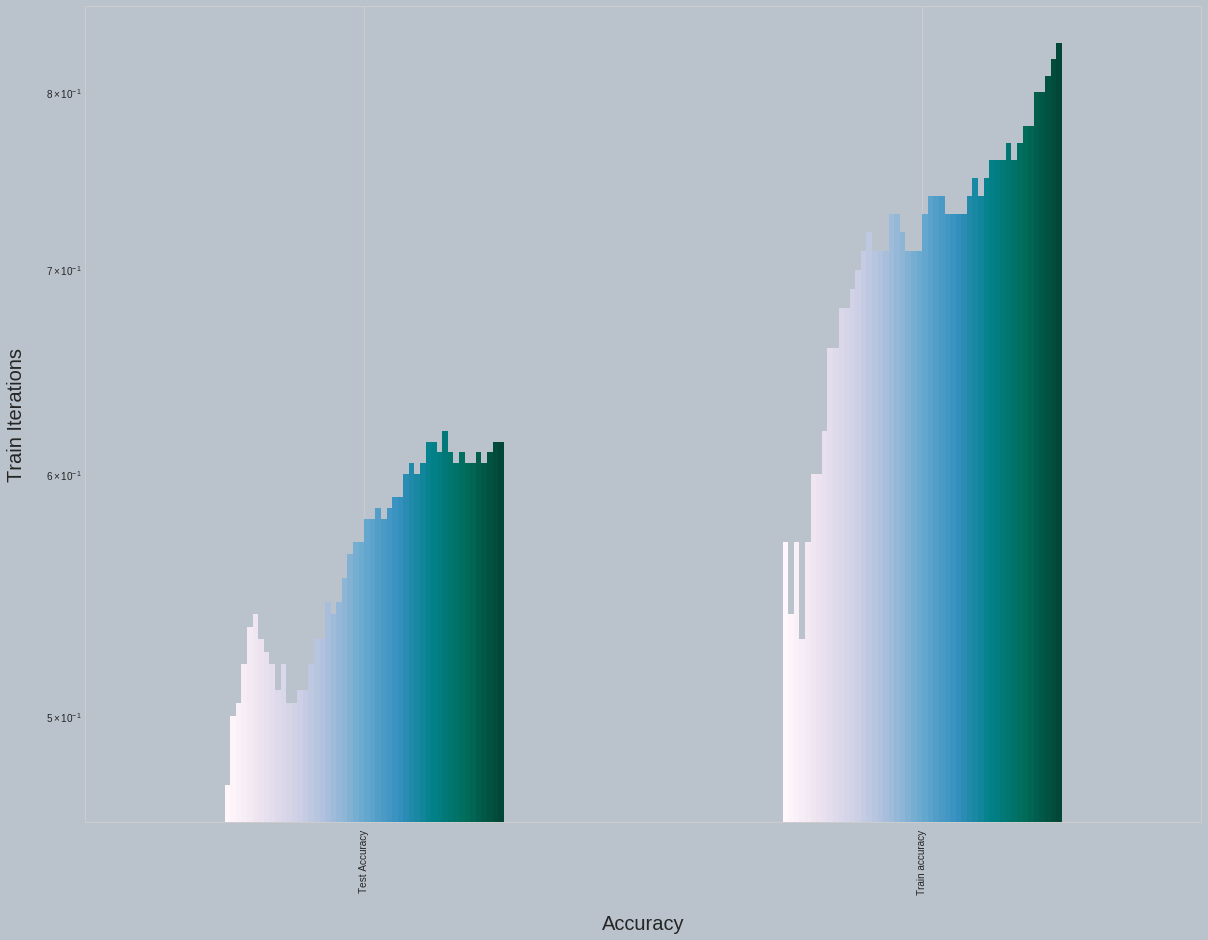

In [259]:
fig, ax = plt.subplots(facecolor='lightslategray')
fig.patch.set_alpha(0.5)
results_df.plot(kind='bar', legend = False, figsize=(20,15), logy=True, colormap='PuBuGn', ax = ax)
ax.set_axis_bgcolor('none')
ax.patch.set_alpha(0.6)

ax.set_xlabel( 'Accuracy', rotation=0, fontsize=20, labelpad=20)
ax.set_ylabel( 'Train Iterations', rotation=90, fontsize=20, labelpad=20)

plt.show()